In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import preprocessing

In [82]:
#トレインデータをpandasで取得
train_data = pd.read_csv("data/application_train.csv")
test_data =  pd.read_csv("data/application_test.csv")

In [83]:
#train_dataの２パターン項目をバイナリにする
#性別をM→1, F→0
#車を持ってたら→1, 持ってなかったら→0
#不動産（Realty）持ってたら→1, 持ってなかったら→0
train_data["CODE_GENDER"] = np.where(train_data["CODE_GENDER"]=="M", 1, 0)
train_data["FLAG_OWN_CAR"] = np.where(train_data["FLAG_OWN_CAR"]=="Y", 1, 0)
train_data["FLAG_OWN_REALTY"] = np.where(train_data["FLAG_OWN_REALTY"]=="Y", 1, 0)

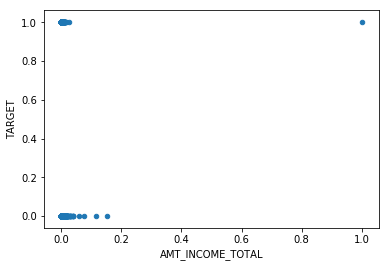

In [81]:
train_data.plot.scatter(x = "AMT_INCOME_TOTAL", y = "TARGET")

In [79]:
#train_data= train_data[train_data.AMT_INCOME_TOTAL <= 0.8*10**8]

In [110]:
#normalize data for neural network
train_data["TARGET"] = train_data["TARGET"].values.astype("float")
train_data["CODE_GENDER"] = train_data["CODE_GENDER"].values.astype("float")
train_data["FLAG_OWN_CAR"] = train_data["FLAG_OWN_CAR"].values.astype("float")
train_data["FLAG_OWN_REALTY"] = train_data["FLAG_OWN_REALTY"].values.astype("float")
train_data["AMT_INCOME_TOTAL"] = train_data["AMT_INCOME_TOTAL"].values.astype("float")
x = train_data[["AMT_INCOME_TOTAL"]].values.astype("float")
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
train_data["AMT_INCOME_TOTAL"] = pd.DataFrame(x_scaled)

In [ ]:
#difine neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 3)
        self.fc2 = nn.Linear(3, 2)
        self.fc3 = nn.Linear(2, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

net = Net()
softmax = nn.Softmax
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)
running_loss = 0

for epoch in range(2):
    for i in range(len(train_data)):
        inputs = torch.tensor([train_data.iloc[i, 3], train_data.iloc[i, 4], train_data.iloc[i, 5], train_data.iloc[i, 7]])
        labels = torch.tensor([train_data.iloc[i, 1]])
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i %10000 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i, running_loss / 10000))
            running_loss = 0.0

[1,     0] loss: 0.000
[1, 10000] loss: 0.280
[1, 20000] loss: 0.280
[1, 30000] loss: 0.285
[1, 40000] loss: 0.284
[1, 50000] loss: 0.276
[1, 60000] loss: 0.275
[1, 70000] loss: 0.281
[1, 80000] loss: 0.280
[1, 90000] loss: 0.283
[1, 100000] loss: 0.286
[1, 110000] loss: 0.297
[1, 120000] loss: 0.276
[1, 130000] loss: 0.281
[1, 140000] loss: 0.280
[1, 150000] loss: 0.289
[1, 160000] loss: 0.275
[1, 170000] loss: 0.277
[1, 180000] loss: 0.276
